In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
from datetime import datetime as date
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  This is definitely going
#  to need further investigation.
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
##### Now only 75% under 25k.
df = df.loc[df.bond_amount<=25000]

# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Change race, gender, facility, and detainer to category type and verify.
misdemeanor_df.race = misdemeanor_df.race.astype('category')
misdemeanor_df.gender = misdemeanor_df.gender.astype('category')
misdemeanor_df.facility = misdemeanor_df.facility.astype('category')
misdemeanor_df.detainer = misdemeanor_df.detainer.astype('category')
misdemeanor_df.offense_class = misdemeanor_df.offense_class.astype('category')
print(misdemeanor_df.info())

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

C:\Users\Misty\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7491 entries, 3 to 28801
Data columns (total 13 columns):
download_date            7491 non-null datetime64[ns]
identifier               7491 non-null object
latest_admission_date    7491 non-null datetime64[ns]
race                     7491 non-null category
gender                   7491 non-null category
age                      7491 non-null int64
bond_amount              7491 non-null int64
offense                  7491 non-null object
facility                 7491 non-null category
detainer                 7491 non-null category
offense_class            7491 non-null category
days                     7491 non-null int64
counts                   7491 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4), object(2)
memory usage: 564.9+ KB
None


In [4]:
target = pd.DataFrame(mis_pre_df.bond_amount)
data = mis_pre_df.drop(['identifier','bond_amount','counts', 
                        'download_date','latest_admission_date',
                        'offense','detainer','facility','age','days'], axis=1)
data = pd.get_dummies(data,columns=['offense_class','race','gender'])
data.drop('offense_class_UM',axis=1,inplace=True)
data.drop('race_ASIAN',axis=1,inplace=True)
data.drop('race_AMER IND',axis=1,inplace=True)
target.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061 entries, 3 to 28799
Data columns (total 9 columns):
offense_class_ M    3061 non-null uint8
offense_class_AM    3061 non-null uint8
offense_class_BM    3061 non-null uint8
offense_class_CM    3061 non-null uint8
race_BLACK          3061 non-null uint8
race_HISPANIC       3061 non-null uint8
race_WHITE          3061 non-null uint8
gender_F            3061 non-null uint8
gender_M            3061 non-null uint8
dtypes: uint8(9)
memory usage: 50.8 KB


((3061, 1), None)

In [5]:
X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

lm = LinearRegression().fit(X_train,y_train)

test = lm.predict(X_test)
lm.score(X_test,y_test)

0.020532298882940503

In [6]:
from statsmodels.formula.api import ols
sm_df = pd.get_dummies(mis_pre_df,columns=['offense_class','race','gender']).rename(
    index=str, columns={'offense_class_ M':'offense_class_M'})

# Same result for gender_M or gender_F
m = ols('bond_amount ~ gender_M',sm_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     12.05
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           0.000525
Time:                        19:36:35   Log-Likelihood:                -31431.
No. Observations:                3061   AIC:                         6.287e+04
Df Residuals:                    3059   BIC:                         6.288e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6275.4228    287.300     21.843      0.0

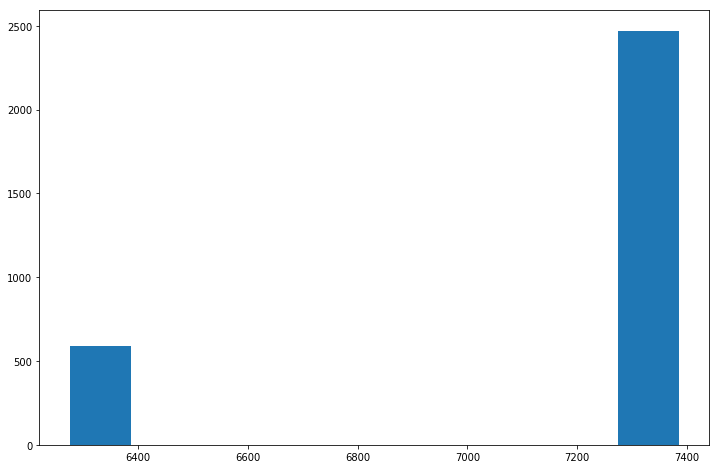

In [7]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.hist(m.fittedvalues)

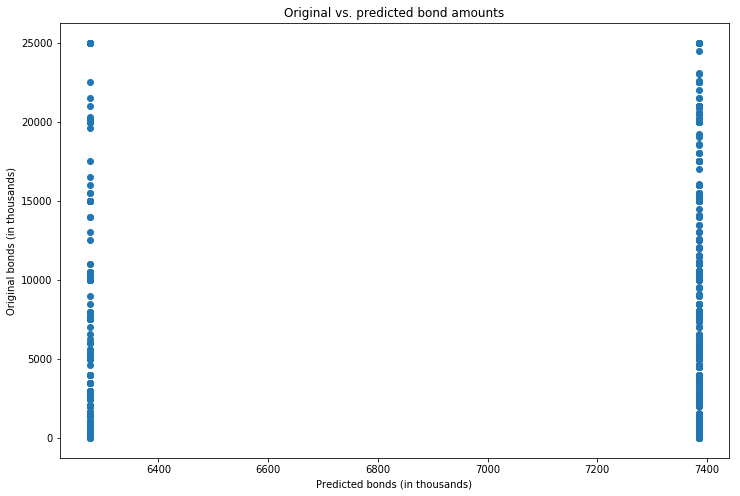

In [8]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.scatter(m.fittedvalues, sm_df.bond_amount)
_ = plt.xlabel('Predicted bonds (in thousands)')
_ = plt.ylabel('Original bonds (in thousands)')
_ = plt.title('Original vs. predicted bond amounts')

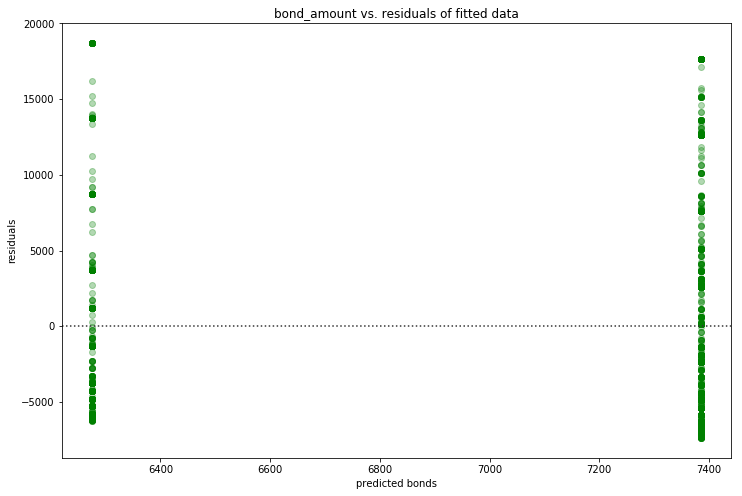

In [9]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(m.fittedvalues, m.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

In [10]:
m = ols('bond_amount ~ offense_class_AM + offense_class_BM + offense_class_CM + race_WHITE + race_BLACK + gender_M',sm_df).fit()
print(m.summary())

# offense_class_M gives 33ish F-stat, BM/CM are less than 20

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     13.11
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           1.07e-14
Time:                        19:36:38   Log-Likelihood:                -31399.
No. Observations:                3061   AIC:                         6.281e+04
Df Residuals:                    3054   BIC:                         6.285e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3171.7144    604.408  

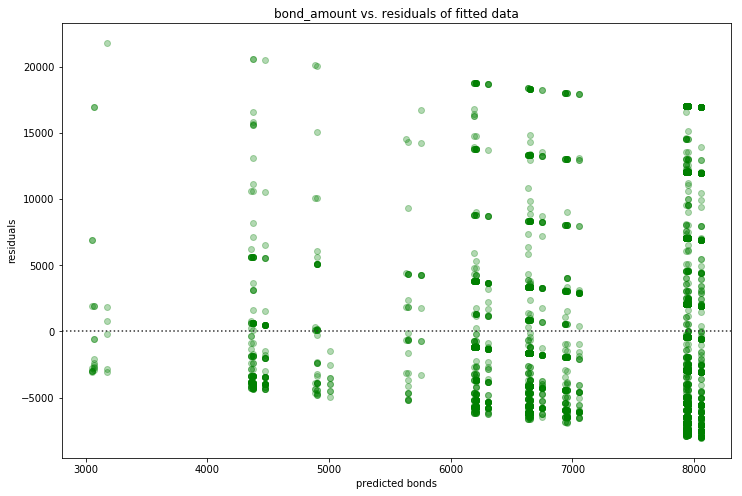

In [11]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(m.fittedvalues, m.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

In [12]:
m = ols('bond_amount ~ race_WHITE',sm_df).fit()
print(m.summary())

# Race alone is crap predictor.  Highest F-stat was less than 10.

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9443
Date:                Sun, 31 Mar 2019   Prob (F-statistic):              0.331
Time:                        19:36:38   Log-Likelihood:                -31437.
No. Observations:                3061   AIC:                         6.288e+04
Df Residuals:                    3059   BIC:                         6.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7278.8030    167.651     43.417      0.0

In [13]:
# Highest F-stat of the above tests
### VIRTUALLY IDENTICAL FOR ALL THREE RACES
### IDENTICAL FOR BOTH GENDERS
### Meh for other offense classes
m = ols('bond_amount ~ race_WHITE + gender_M + offense_class_AM',sm_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     20.53
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           3.60e-13
Time:                        19:36:39   Log-Likelihood:                -31407.
No. Observations:                3061   AIC:                         6.282e+04
Df Residuals:                    3057   BIC:                         6.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4739.3258    391.585  

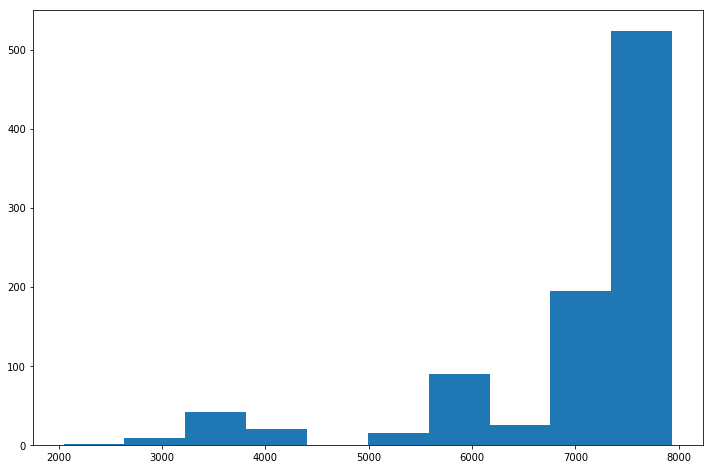

In [14]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.hist(test)

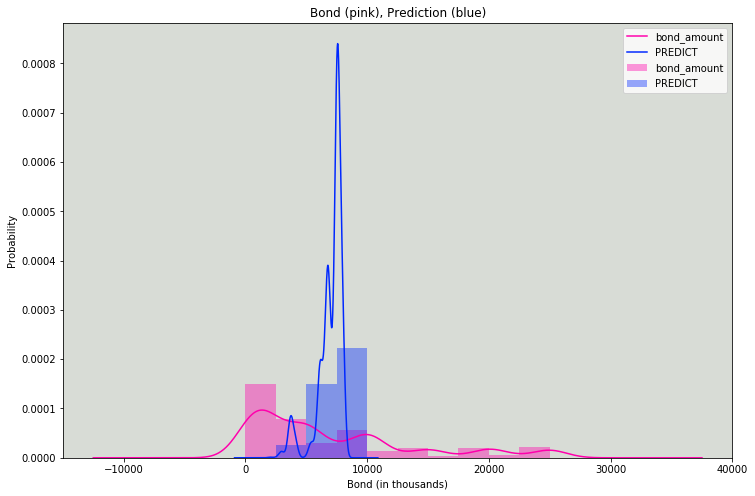

In [15]:
new = target.copy()
new['PREDICT'] = lm.predict(X)

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = new[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)');

# Restart everything.  Attempt log transforms after this.  

In [16]:
target_a = pd.DataFrame(mis_pre_df.bond_amount)
data_a = mis_pre_df.drop(['identifier','bond_amount','counts', 
                        'download_date','latest_admission_date',
                        'offense','detainer','facility','age','days'], axis=1)
data_a = pd.get_dummies(data_a,columns=['offense_class','race','gender'],drop_first=True)
#data_a.drop('offense_class_UM',axis=1,inplace=True)
#data_a.drop('race_ASIAN',axis=1,inplace=True)
#data_a.drop('race_AMER IND',axis=1,inplace=True)
data_a.drop(['offense_class_UM','race_ASIAN'],axis=1,inplace=True)
target_a.shape, data_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061 entries, 3 to 28799
Data columns (total 7 columns):
offense_class_AM    3061 non-null uint8
offense_class_BM    3061 non-null uint8
offense_class_CM    3061 non-null uint8
race_BLACK          3061 non-null uint8
race_HISPANIC       3061 non-null uint8
race_WHITE          3061 non-null uint8
gender_M            3061 non-null uint8
dtypes: uint8(7)
memory usage: 44.8 KB


((3061, 1), None)

# Linear log after cutting data down to <25k, doesn't help the score at all.

In [17]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

lin = LinearRegression()
lin.fit(X_train,y_train)
lin.predict(X_test)
lin.score(X_test,y_test)
lin.coef_

array([[ 0.80549202,  0.70778775,  0.53983771, -0.19983184, -0.01067184,
         0.02346009,  0.08282047]])

# Statsmodels log for next few blocks.  Why does this work and no other model appear to work at all?

Btw, the r^2 went from .5ish (when data cut to <25k) to .96ish (when log transform added), so I'm not convinced this is working either.  F-stat blew through the roof, too, and log-likelihood is significantly lower.  P-vals for everything are now 0 or tiny.  I really don't know if this is trustable AT ALL.

In [18]:
X = data_a
y = target_a.transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

linear = sm.OLS(y_train,X_train).fit()
predict = linear.predict(X_test)
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     8741.
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:36:41   Log-Likelihood:                -3952.3
No. Observations:                2142   AIC:                             7919.
Df Residuals:                    2135   BIC:                             7958.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
offense_class_AM     2.3596      0.123  

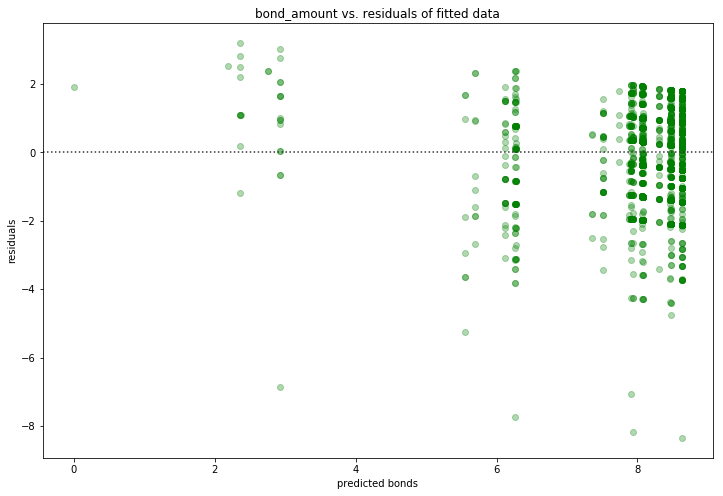

In [19]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(linear.fittedvalues, linear.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

Text(0,0.5,'fitted')

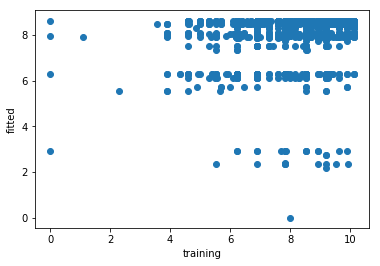

In [20]:
plt.scatter(y_train,linear.fittedvalues)
plt.xlabel('training')
plt.ylabel('fitted')

# So even though the training values go to 25k, the fitted vals only go to 8k...

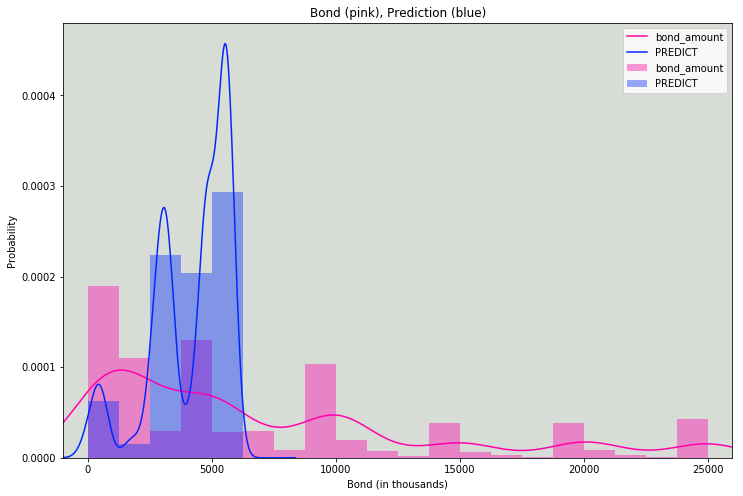

In [21]:
plt_75 = target_a.copy()
plt_75['PREDICT'] = linear.fittedvalues.transform(lambda x: np.exp(x))

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = plt_75[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country, bins=20)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)')
ax.set_xlim(-1000,26000);

# Attempt at KNN Regression.  Same issues as Linear.

As usual, I like this idea.  I just cannot figure out how to make plots from it to even start seeing where I'm going wrong.

In [22]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

knr = KNeighborsRegressor(n_neighbors=11).fit(X_train,y_train)

knr.predict(X_test)
knr.score(X_test,y_test)

-0.046040978630251805

In [ ]:
# Here's statsmodels with 10k.  It doesn't matter what I choose.  The predicts cut off at 4000 when 10k is chosen and cut off at 3500 when 7.5k (the median)

In [26]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

linear = sm.OLS(y_train,X_train).fit()
predict = linear.predict(X_test)
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     5760.
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:39:22   Log-Likelihood:                -2407.2
No. Observations:                1383   AIC:                             4828.
Df Residuals:                    1376   BIC:                             4865.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
offense_class_AM     1.8251      0.125  

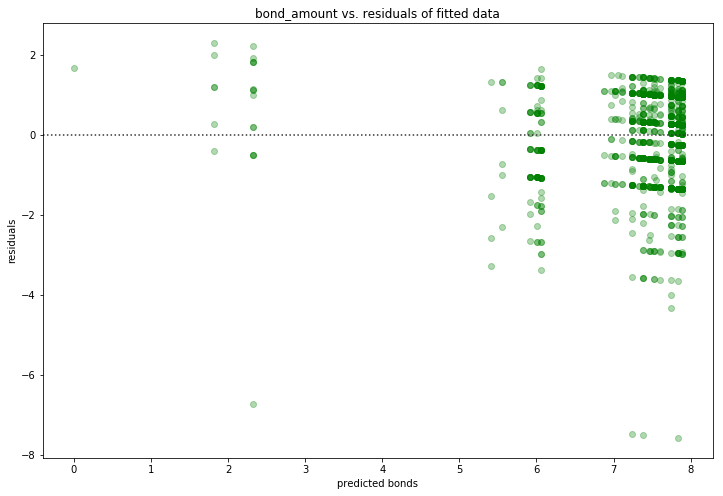

In [27]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(linear.fittedvalues, linear.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

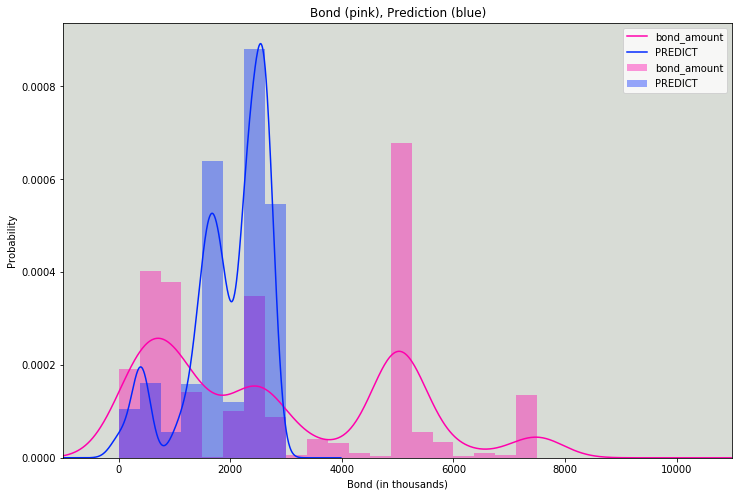

In [28]:
plt_50 = target_a.loc[target_a.bond_amount<=10000].copy()
plt_50['PREDICT'] = linear.fittedvalues.transform(lambda x: np.exp(x))

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = plt_50[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country, bins=20)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)')
ax.set_xlim(-1000,11000);